# Captcha Solver
At least an attempt I guess, didn't work out tho :(

### Import Image

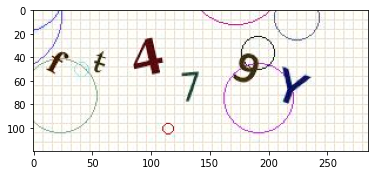

(120, 285, 3)


In [188]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import interpolation as inter
import itertools
import pytesseract
import requests
import json
import imutils
import tqdm
from pprint import pprint
from PIL import Image

captcha_path = './captcha_images/1.jpeg'
img = cv2.imread(captcha_path)
imgplot = plt.imshow(img)
plt.show()
print(img.shape)


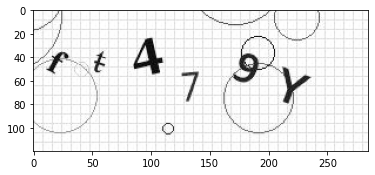

In [189]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgplot = plt.imshow(gray, cmap='gray')
plt.show()

### Otsu Transformation

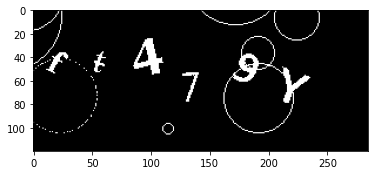

In [190]:
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
imgplot = plt.imshow(thresh, cmap='gray')
plt.show()

### Erosion Followed by Dilation

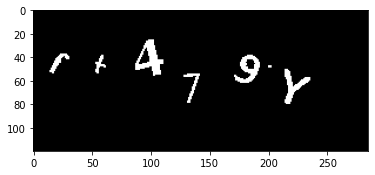

In [191]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((2,2), np.uint8)
 
img_erosion = cv2.erode(thresh, kernel, iterations=1)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)

imgplot = plt.imshow(img_dilation, cmap='gray')
plt.show()

## Find Contours

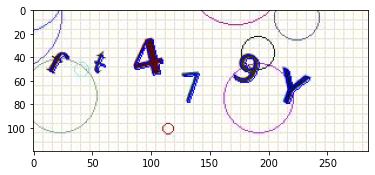

Number of contours:  8


In [192]:

items = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = items[0] if len(items) == 2 else items[1]

img_contour = img.copy()
selected_countours = []
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    # print(area)
    if area > 10:
        selected_countours.append(contours[i])
        cv2.drawContours(img_contour, contours, i, (0, 0, 255), 0)

imgplot = plt.imshow(img_contour)
plt.show()
print("Number of contours: ", len(selected_countours))

## Get Bounding Boxes from Contours

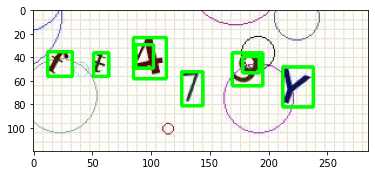

In [193]:
bound_expansion = 2
bounded_img = img.copy()
boxes = []
for i in range(len(selected_countours)):
    x, y, w, h = cv2.boundingRect(selected_countours[i])
    x -= bound_expansion
    y -= bound_expansion
    w += 2*bound_expansion
    h += 2*bound_expansion
    boxes.append((x, y, w, h))
    cv2.rectangle(bounded_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

imgplot = plt.imshow(bounded_img)
plt.show()


### Combine Overlapping Boxes

[(12, 35, 21, 21),
 (51, 36, 13, 20),
 (85, 23, 28, 35),
 (126, 52, 18, 29),
 (169, 36, 26, 28),
 (212, 48, 26, 34)]


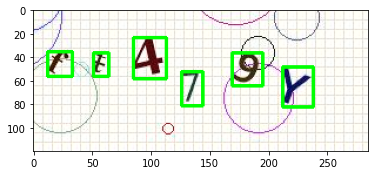

In [194]:
# Combined Boxes
def union(a,b):
  x = min(a[0], b[0])
  y = min(a[1], b[1])
  w = max(a[0]+a[2], b[0]+b[2]) - x
  h = max(a[1]+a[3], b[1]+b[3]) - y
  return (x, y, w, h)

def intersection(a,b):
  x = max(a[0], b[0])
  y = max(a[1], b[1])
  w = min(a[0]+a[2], b[0]+b[2]) - x
  h = min(a[1]+a[3], b[1]+b[3]) - y
  if w<0 or h<0: return () # or (0,0,0,0) ?
  return (x, y, w, h)

def merge_recs(rects):
    while (1):
        found = 0
        for ra, rb in itertools.combinations(rects, 2):
            if intersection(ra, rb):
                if ra in rects:
                    rects.remove(ra)
                if rb in rects:
                    rects.remove(rb)
                rects.append((union(ra, rb)))
                found = 1
                break
        if found == 0:
            break

    return rects
boxes = merge_recs(boxes)
boxes.sort()
pprint(boxes)

grouped_bounded_img = img.copy()
for i in range(len(boxes)):
    x, y, w, h = boxes[i]
    cv2.rectangle(grouped_bounded_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

imgplot = plt.imshow(grouped_bounded_img)
plt.show()


## Extract Characters

In [195]:
def Reformat_Image(ImageFilePath):

    image = Image.open(ImageFilePath, 'r')
    image_size = image.size
    width = image_size[0]
    height = image_size[1]

    if(width != height or (width < 50 and height < 50)):
        bigside = width if width > height else height
        if bigside < 50:
            bigside = 50

        background = Image.new('RGB', (bigside, bigside), (255, 255, 255))
        offset = (int(round(((bigside - width) / 2), 0)), int(round(((bigside - height) / 2),0)))

        background.paste(image, offset)
        background.save(ocr_image_file)
        print("Image has been resized !")
        print(background.size)

    else:
        print("Image is already a square, it has not been resized !")

## Stuff for Azure 
ocr_api = "https://southcentralus.api.cognitive.microsoft.com/vision/v3.2/read/analyze"
ocr_key = "redacted"

params ={"language": "en" }

# Stuff for Tesseract
config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

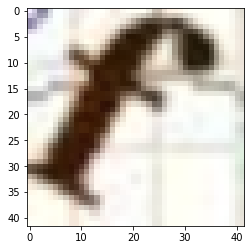

100%|██████████| 40/40 [00:04<00:00,  8.47it/s]


[('e', 18452.48021285892), ('f', 11419.689629669261), ('F', 8592.081246054582), ('r', 5924.307019091966), ('a', 4784.597373342491), ('i', 4714.982475141634), ('t', 3975.623507689794), ('v', 2919.910635784817), ('l', 2842.6498798110215), ('y', 2776.81338770458), ('I', 1970.299400935049), ('o', 1916.861561236694), ('w', 992.0), ('L', 929.9072043644998)]
BEST GUESS:  e


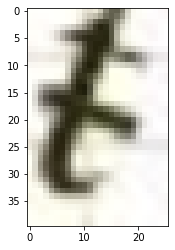

100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


[('e', 17411.384699205923), ('t', 5981.975420452547), ('E', 4617.277872969088), ('z', 3917.1553853678797), ('r', 3804.9829457079054), ('T', 3706.72059206908), ('a', 2869.564704509602), ('i', 2868.713253823552), ('I', 2776.81338770458), ('f', 994.8038475772934), ('d', 994.8038475772934), ('J', 968.3772233983162), ('j', 958.430780618347), ('7', 953.1278334189682), ('3', 941.9052498068887), ('g', 941.9052498068887), ('Y', 910.5572809000084)]
BEST GUESS:  e


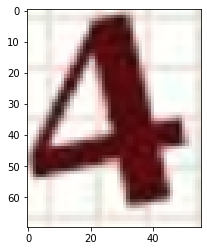

100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


[('A', 21678.172505968578), ('4', 8471.31837980454), ('N', 6540.453283591568), ('s', 5582.022502973221), ('I', 1935.8033636203775), ('B', 936.0), ('e', 936.0)]
BEST GUESS:  A


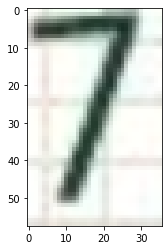

100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


[('7', 11775.104024380427), ('i', 4846.3614265892975), ('a', 2751.3706686045884), ('f', 1998.0), ('A', 1865.9072043644996), ('1', 941.9052498068887)]
BEST GUESS:  7


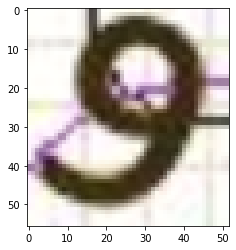

100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


[('5', 10526.54287639355), ('S', 6677.034976654185), ('9', 5739.834798965523), ('F', 3990.975420452547), ('D', 3906.102764555427), ('L', 3789.34303561673), ('3', 2990.975420452547), ('A', 1955.5171273060905), ('y', 1870.3087534916954), ('P', 992.0), ('X', 988.8196601125011), ('K', 981.4797408225479), ('I', 977.3725830020305), ('R', 953.1278334189682), ('C', 936.0), ('g', 936.0), ('k', 917.1809200727272), ('G', 910.5572809000084), ('7', 910.5572809000084)]
BEST GUESS:  5


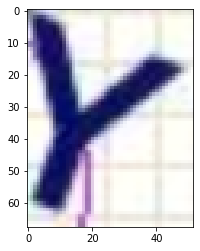

100%|██████████| 40/40 [00:04<00:00,  8.31it/s]

[('y', 18560.013954490474), ('Y', 6541.74000488798), ('i', 4799.447853779165), ('I', 3830.8672373160125), ('a', 3752.2003328916276), ('l', 3712.6258418759685), ('4', 2878.3417065045546), ('K', 1938.4308949622691), ('g', 1914.9052498068886), ('b', 988.8196601125011), ('k', 985.3030615433009), ('q', 977.3725830020305), ('e', 953.1278334189682), ('v', 936.0), ('V', 910.5572809000084)]
BEST GUESS:  y


In [187]:
ocr_image_file = './roi.jpg'
for box in boxes:
    image_roi = img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    image_roi = cv2.resize(image_roi, (0,0), fx=2, fy=2) 
    plt.imshow(image_roi)
    plt.show()
    
    bounds = 20
    candidate_characters = {}
    for angle in tqdm.trange(-bounds, bounds, 0.5):
        # Rotate the image and display it
        rotated = imutils.rotate_bound(image_roi, angle)
        text = pytesseract.image_to_string(rotated, lang='eng', config=config)
        
        for c in text:
            if c.isalnum():   
                if not c in candidate_characters:
                    candidate_characters[c] = 0
                candidate_characters[c] += 1000 - abs(angle)**1.5
        
    max_score = max(candidate_characters.values())
    best_guess = [k for k, v in candidate_characters.items() if v == max_score][0]
    
    print(sorted(candidate_characters.items(), key=lambda x: x[1], reverse=True))
    print("BEST GUESS: ",best_guess)
    

    

